In [375]:
!pip install pandas
!pip install pyyaml
!pip install hpo3

DEPRECATION: o365 2.0.16 has a non-standard dependency specifier tzlocal<3.*,>=1.5.0. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of o365 or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


DEPRECATION: o365 2.0.16 has a non-standard dependency specifier tzlocal<3.*,>=1.5.0. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of o365 or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


DEPRECATION: o365 2.0.16 has a non-standard dependency specifier tzlocal<3.*,>=1.5.0. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of o365 or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [376]:
import os
import pandas as pd
from pyhpo import Ontology, HPOSet, Omim, stats
import yaml

Ontology(os.path.join(os.getcwd(), 'phoenotype', 'rawdl_20240310'))

In [377]:
# Declare the folder path for phenotype data source
phenotype_folder = os.path.join(os.getcwd(), 'phenotype', 'subset')

# Declare 7 Files
icd10omim = 'icd102omim_subset.tsv'
loinc2hpo = 'loinc2hpo_standardized.tsv'
omim2hpo = 'omim2hpo_subset.tsv'
orpha2omim = 'orpha2omim_subset.tsv'
orpha2hpo = 'orpha2hpo_subset.tsv'
snomed2hpo = 'snomed2hpo_subset.tsv'
snomed2orpha = 'snomed2orpha_subset.tsv'

# iderare yaml configuration file
yaml_file = 'iderare.yaml'

# Clinical data dummy in txt format separated with new line
clinical_data = 'clinical_data.txt'

In [378]:
# Read the clinical data and parse the data
icd10omim_df = pd.read_csv(os.path.join(phenotype_folder, icd10omim), sep='\t')
loinc2hpo_df = pd.read_csv(os.path.join(phenotype_folder, loinc2hpo), sep='\t')
omim2hpo_df = pd.read_csv(os.path.join(phenotype_folder, omim2hpo), sep='\t')
orpha2omim_df = pd.read_csv(os.path.join(phenotype_folder, orpha2omim), sep='\t')
orpha2hpo_df = pd.read_csv(os.path.join(phenotype_folder, orpha2hpo), sep='\t')
snomed2hpo_df = pd.read_csv(os.path.join(phenotype_folder, snomed2hpo), sep='\t')
snomed2orpha_df = pd.read_csv(os.path.join(phenotype_folder, snomed2orpha), sep='\t')

In [379]:
# Read line from clinical_data and parse the data to list
with open(clinical_data, 'r') as file:
    clinical_data_list = file.read().splitlines()

clinical_data_list

['SNOMEDCT:65959000',
 'SNOMEDCT:11179002',
 'ICD-10:E75.2',
 'SNOMEDCT:258211005',
 'SNOMEDCT:80515008',
 'SNOMEDCT:389026000',
 'LOINC:2862-1|L',
 'LOINC:718-7|L']

In [380]:
def common_elements(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    return list(set1.intersection(set2))

In [381]:
# HPO Parser for Clinical Finding Related Terminology such as SNOMED, LOINC
def hpo_parser(clinical_data, df):    
    print('Trying to parse HPO from terminology', clinical_data)
    
    # LOINC case
    if 'LOINC:' in clinical_data:
        loinc_split = clinical_data.split('|')
        # Ensure that the forwarded data contain both LOINC and its interpretation
        if len(loinc_split) == 2:
            loinc = loinc_split[0]
            interpretation = loinc_split[1]
            
            # Handling if LOINC code not found in the database
            if loinc not in df['loinc'].unique() :
                print('LOINC data is not found in the database, please check the exact LOINC code.')
                loinc_sugg = df[df['loinc'].str.contains(loinc.strip('LOINC:'))]['loinc'].drop_duplicates()
                print('Did you mean any of this code:', (', ').join(loinc_sugg.values) , '?\n')
                return []
            
            loinc_hpo = df[df['loinc'] == loinc]

            # Handling if interpretation not suitable for the LOINC code
            if interpretation not in loinc_hpo['interpretation'].unique() :
                print('Interpretation is invalid, please check if you have used correct interpretation.')
                interpretation_sugg = df[df['loinc']==loinc]['interpretation'].drop_duplicates()
                print('Available interpretation for code', loinc, ' : ', (' or ').join(interpretation_sugg.values) , '\n')
                return []
            
            loinc_hpo = loinc_hpo[loinc_hpo['interpretation'] == interpretation]['hpoTermId'].to_list()
            print('Parsing of', clinical_data, 'successful with result of :', loinc_hpo, '\n')
            return loinc_hpo
        else:
            print('LOINC data is missing either code / interpretation.')
            print('Example : LOINC:721-1|H for Qn lab examination OR LOINC:721-1|NEG for Nominal / Ordinal Lab Examination', '\n')
            return []
        
    # SNOMED-CT case
    elif 'SNOMEDCT:' in clinical_data:
        if clinical_data not in df['SNOMED_CT_ID'].unique() :
            print('This SNOMED-CT code is not a clinical finding mapped with HPO, please check the SNOMED to OMIM for diagnosis mapping.')
            snomed_sugg = df[df['SNOMED_CT_ID'].str.contains(clinical_data.strip('SNOMEDCT:'))]['SNOMED_CT_ID'].drop_duplicates()
            print('Sugggestion : It is possible that you mean any of this code:', (', ').join(snomed_sugg.values) , '?\n')
            return []
        else : 
            snomed_hpo = df[df['SNOMED_CT_ID'] == clinical_data]['HPO_ID'].to_list()
            print('Parsing of', clinical_data, 'successful with result of :', len(snomed_hpo), ' HPO code : ', (', ').join(snomed_hpo), '\n')
            return snomed_hpo
        
    # Not recognized case
    else:
        print('The terminology is not recognized, please check if you have used correct terminology.')
        print('Example : LOINC:2862-1|L for Qn lab examination OR LOINC:725-2|NEG for categoric lab examination of SNOMEDCT:48610005 for Clinical Finding', '\n')
        return []

In [382]:
def snomed_orpha_parser(clinical_data, df):
    print('Trying to parse ORPHA from SNOMED-CT', clinical_data)
    
    if 'SNOMEDCT:' in clinical_data:
        if clinical_data not in df['code'].unique() :
            print('This SNOMED-CT code is not a clinical finding mapped with ORPHA, please check the SNOMED to ORPHA for diagnosis mapping.')
            snomed_sugg = df[df['code'].str.contains(clinical_data.strip('SNOMEDCT:'))]['code'].drop_duplicates()
            print('Sugggestion : It is possible that you mean any of this code:', (', ').join(snomed_sugg.values) , '?\n')
            return []
        else : 
            snomed_orpha = df[df['code'] == clinical_data]['orphanet_map'].to_list()
            print('Parsing of', clinical_data, 'successful with result of :', len(snomed_orpha), ' ORPHA code : ', (', ').join(snomed_orpha), '\n')
            return snomed_orpha
        
    else :
        print('The terminology is not recognized, please check if you have used correct terminology.')
        print('Allowable format : SNOMEDCT disorder semantic only SNOMEDCT:1212005', '\n')
        return []

In [383]:
# OMIM Parser used for diagnosis related terminology such as ICD-10, ORPHA, SNOMED-CT
def omim_parser(clinical_data,df):
    print('Trying to parse OMIM from terminology', clinical_data)

    # ICD-10 case
    if 'ICD-10:' in clinical_data:
        if clinical_data not in df['ICD10'].unique() :
            print('ICD-10 data is not found in the database, please check the exact ICD-10 code.')
            icd_sugg = df[df['ICD10'].str.contains(clinical_data.strip('ICD-10:'))]['ICD10'].drop_duplicates()
            print('Did you mean any of this code:', (', ').join(icd_sugg.values) , '?\n')
            return []
        else : 
            icd_omim = df[df['ICD10'] == clinical_data]['OMIM'].to_list()
            print('Parsing of', clinical_data, 'successful with result of :', len(icd_omim), ' OMIM code : ', (', ').join(icd_omim), '\n')
            return icd_omim
        
    # ORPHA case
    elif 'ORPHA:' in clinical_data:
        if clinical_data not in df['ORPHA'].unique() :
            print('ORPHA data is not found in the database, please check the exact ORPHA code.')
            orpha_sugg = df[df['ORPHA'].str.contains(clinical_data.strip('ORPHA:'))]['ORPHA'].drop_duplicates()
            print('Did you mean any of this code:', (', ').join(orpha_sugg.values) , '?\n')
            return []
        else : 
            orpha_hpo = df[df['ORPHA'] == clinical_data]['OMIM'].to_list()
            print('Parsing of', clinical_data, 'successful with result of :', len(orpha_hpo), ' OMIM code : ', (', ').join(orpha_hpo), '\n')
            return orpha_hpo
    
    else:
        print('The terminology is not recognized, please check the input format.')
        print('Allowable format is : ICD-10:xxxx OR ORPHA:xxxxx for clinical disorder', '\n')
        return []

In [384]:
# Example of hpo_parser for Clinical Finding (LOINC & SNOMED)
hpo_result = []
loinc_hpo_example = hpo_parser('LOINC:2862-1|L', loinc2hpo_df)
snomed_hpo_example = hpo_parser('SNOMEDCT:249627005', snomed2hpo_df)

# Initiate List or Append
hpo_result.extend(loinc_hpo_example)
hpo_result.extend(snomed_hpo_example)

print("Result of :", len(hpo_result), "HPO code(s) from loinc_hpo_example and snomed_hpo_example\n")

# Example of OMIM Parser for Diagnosis
omim_hpo_result = []
icd_omim_example = omim_parser('ICD-10:E75.2', icd10omim_df)
orpha_omim_example = omim_parser('ORPHA:848', orpha2omim_df)
snomed_orpha_example = snomed_orpha_parser('SNOMEDCT:11179002', snomed2orpha_df)

snomed_omim_example = []
for i in range(len(snomed_orpha_example)) :
    snomed_omim_example = snomed_omim_example + omim_parser(snomed_orpha_example[i], orpha2omim_df)

# Extend the result, but exclude the ICD OMIM since the code itself is unspecific and give too many unspecific result
# omim_hpo_result.extend(icd_omim_example)    
omim_hpo_result.extend(icd_omim_example)
# omim_hpo_result.extend(orpha_omim_example)
# omim_hpo_result.extend(snomed_omim_example)

print("Result of :", len(omim_hpo_result), "OMIM code(s) from Diagnosis Code")
print("Result of :", len(set(omim_hpo_result)), "unique OMIM code(s) from Diagnosis Code")

Trying to parse HPO from terminology LOINC:2862-1|L
Parsing of LOINC:2862-1|L successful with result of : ['HP:0003073'] 

Trying to parse HPO from terminology SNOMEDCT:249627005
Parsing of SNOMEDCT:249627005 successful with result of : 1  HPO code :  HP:0002249 

Result of : 2 HPO code(s) from loinc_hpo_example and snomed_hpo_example

Trying to parse OMIM from terminology ICD-10:E75.2
Parsing of ICD-10:E75.2 successful with result of : 46  OMIM code :  OMIM:228000, OMIM:603896, OMIM:203450, OMIM:616140, OMIM:613926, OMIM:613925, OMIM:604004, OMIM:608804, OMIM:612233, OMIM:260600, OMIM:300523, OMIM:312080, OMIM:611721, OMIM:615281, OMIM:272200, OMIM:221790, OMIM:607616, OMIM:245200, OMIM:611722, OMIM:613724, OMIM:231005, OMIM:607694, OMIM:257200, OMIM:615889, OMIM:617762, OMIM:271900, OMIM:250100, OMIM:231000, OMIM:213900, OMIM:257220, OMIM:607625, OMIM:608013, OMIM:617899, OMIM:612438, OMIM:221820, OMIM:169500, OMIM:249900, OMIM:156310, OMIM:610539, OMIM:230900, OMIM:612951, OMIM:6091

In [385]:
# def omim_hpo_intersecter(omim_list, df, diagnosis_phen_sim_threshold=0.8):
#     ## Explanation : 
    
#     # 1. diagnosis_phen_sim_threshold is a threshold to determine the intersection of HPO between the diagnosis
#     # Suppose you have 10 OMIM diagnosis code, and the threshold is 0.9, then the HPO code returned would be the one that occur at least 9 times
#     # If the threshold is 0.5, then the HPO code returned would be the one that occur at least 5 times
    
#     # Number the OMIM code that will be check as phenotype relationship 
#     threshold = diagnosis_phen_sim_threshold * len(omim_list)
    
#     # Result out the data that at least occur more than threshold
#     if len(omim_list) > 0:
#         omim_list = set(omim_list)
#         omim_hpo = df[df['disease_id'].isin(omim_list)]

#         # Get Index of valuecounts that is more than threshold
#         hpo_count = omim_hpo['hpo_id'].value_counts()
#         # Get the count of HPO code
#         print(hpo_count)

#         # Get the HPO code(s) that is on the highest counts or more than threshold
#         omim_hpo = omim_hpo[omim_hpo['hpo_id'].isin(hpo_count)]
#         disease_id = omim_hpo['disease_id'].drop_duplicates().to_list()

#         # Deduplicate to get the set only
#         hpo_set = set(omim_hpo['hpo_id'].to_list())
#         disease_set = set(disease_id)
        
#         return hpo_set, disease_set

OMIM code OMIM:156310 is not found in the database, please check the exact OMIM code.


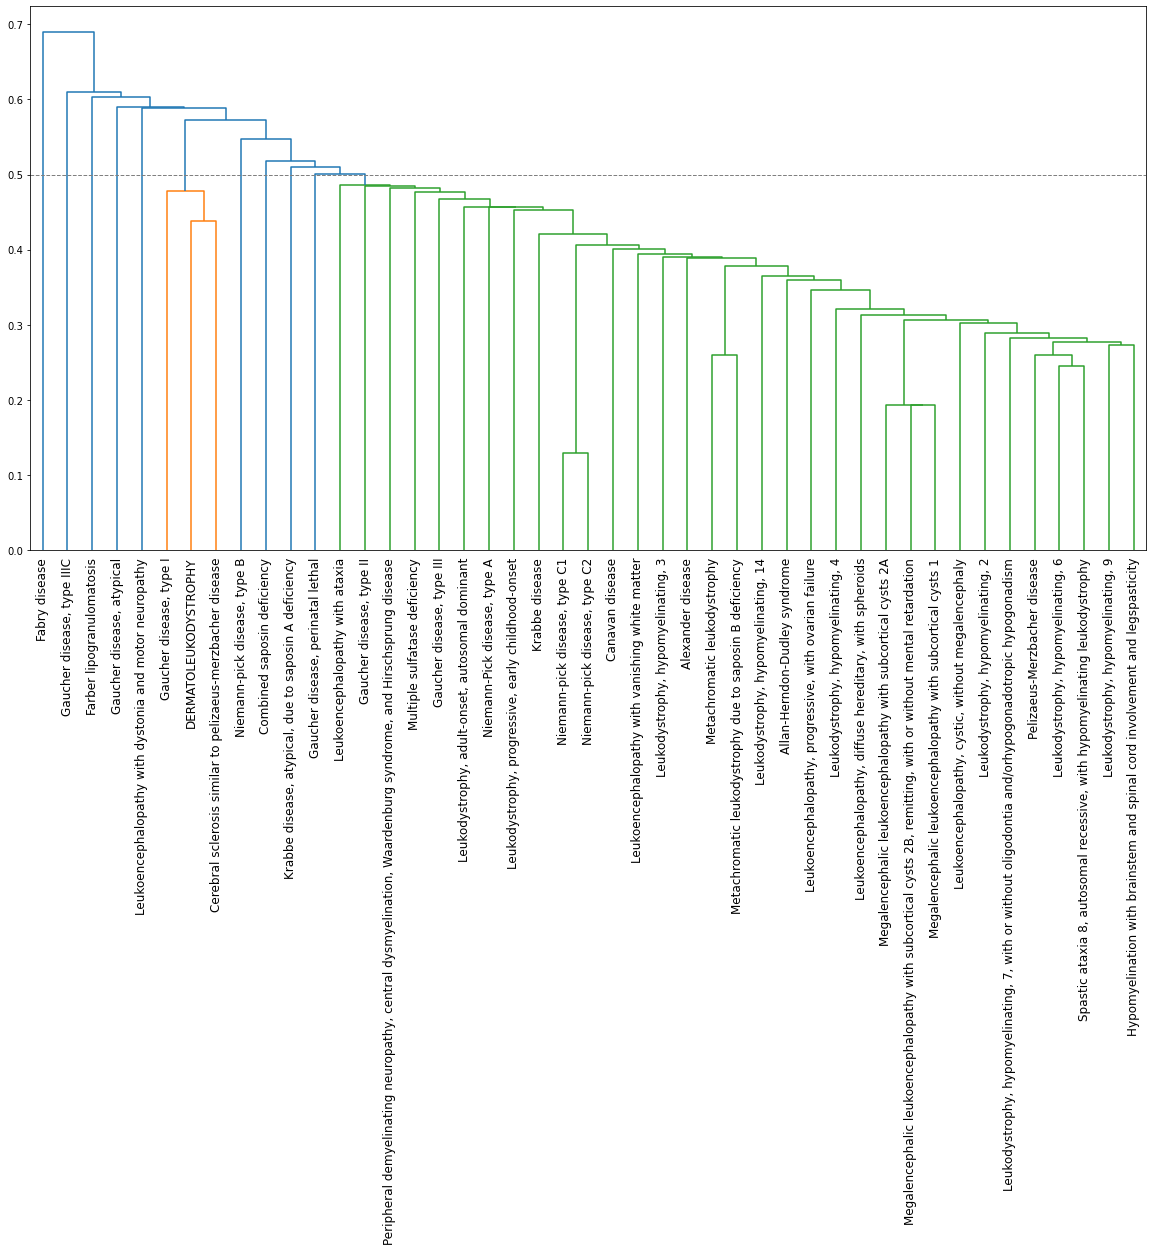

In [386]:
linkage_disease = []
for item in omim_hpo_result:
    try : 
        disease = Omim.get(int(item.strip('OMIM:')))
        linkage_disease.append(disease)
    except:
        print('OMIM code', item, 'is skipped.')
        continue
    # disease.hpo_set()
    
# Using diseases and creating a Tuple of (Disease Name, HPOSet) for each
diseases = [(d.name, HPOSet(list(d.hpo)).remove_modifier()) for d in linkage_disease]

# Creating one list with all HPOSets
disease_sets = [d[1] for d in diseases]
# And one list with the names of diseases
names = [d[0] for d in diseases]

# Cluster the diseases using default settings
lnk = stats.linkage(disease_sets)

# For plotting, you can use `scipy`
import scipy.cluster
from matplotlib import pyplot as plt

plt.figure(figsize=(20, 10))
scipy.cluster.hierarchy.dendrogram(lnk, labels=names, show_contracted=True, leaf_font_size=12, leaf_rotation=90, color_threshold=0.5)
plt.axhline(y=0.5, c='grey', lw=1, linestyle='dashed')

In [389]:
hpo_set, disease_set = omim_hpo_intersecter(omim_hpo_result, omim2hpo_df, 0.8)

HP:0034345    43
HP:0000007    36
HP:0000005    36
HP:0031797    30
HP:0012823    30
              ..
HP:0002143     1
HP:0032794     1
HP:0032792     1
HP:0002910     1
HP:0001138     1
Name: hpo_id, Length: 1056, dtype: int64


In [390]:
hpo_set, len(disease_set)

(set(), 0)

In [391]:
# If LOINC / SNOMED with only single result --> return back only the HPO, 
# But if diagnosis code with multiple result --> store it as temporary data and then find the similarity of phenotype first